Importacion librerias

In [48]:

import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Leo todos los CSV de la carpeta 'Data' y los uno en un único DataFrame.

In [49]:
#Cargar todos los CSV de Data/
data_dir = "Data"

csv_files = [
    f for f in os.listdir(data_dir)
    if f.endswith(".csv") and not f.startswith("unclean")
]

dfs = []
for file in csv_files:
    brand = file.replace(".csv", "")   
    path = os.path.join(data_dir, file)
    df = pd.read_csv(path)
    df["brand"] = brand
    dfs.append(df)

cars = pd.concat(dfs, ignore_index=True)

#Unificar modelos especiales (focus y cclass)
cars['brand'] = cars['brand'].replace({
    'focus': 'ford',
    'cclass': 'mercedes'
})


# Visualizaciones


In [50]:
cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           94327 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   brand         108540 non-null  object 
 10  tax(£)        4860 non-null    float64
dtypes: float64(4), int64(3), object(4)
memory usage: 9.1+ MB


In [51]:
cars['brand'].value_counts()


brand
ford           23419
mercedes       17018
volkswagen     15157
Opel           13632
bmw            10781
audi           10668
toyota          6738
skoda           6267
hyundai         4860
Name: count, dtype: int64

In [52]:
cars.isna().sum()


model                0
year                 0
price                0
transmission         0
mileage              0
fuelType             0
tax              14213
mpg               9353
engineSize           0
brand                0
tax(£)          103680
dtype: int64

Conversion de Millas a Km y galones a L

In [54]:
MILES_TO_KM = 1.60934 #Aproximacion de Millas a Km
IMP_MPG_TO_L_100KM = 282.481  #Aproximacion  Galones a L

cars['mileage_km'] = cars['mileage'] * MILES_TO_KM
cars['consumption_l_100km'] = IMP_MPG_TO_L_100KM / cars['mpg']

#Quito columnas antiguas:
cars = cars.drop(columns=['mileage', 'mpg'])


# Conversion de GBP a EUR

In [55]:
#GBP a EUR
GBP_TO_EUR = 1.17
cars['price_eur'] = cars['price'] * GBP_TO_EUR

#Nueva variable objetivo
target = 'price_eur'

In [56]:
cars.head()
cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   model                108540 non-null  object 
 1   year                 108540 non-null  int64  
 2   price                108540 non-null  int64  
 3   transmission         108540 non-null  object 
 4   fuelType             108540 non-null  object 
 5   tax                  94327 non-null   float64
 6   engineSize           108540 non-null  float64
 7   brand                108540 non-null  object 
 8   tax(£)               4860 non-null    float64
 9   car_age              108540 non-null  int64  
 10  mileage_km           108540 non-null  float64
 11  consumption_l_100km  99187 non-null   float64
 12  price_eur            108540 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 10.8+ MB


In [57]:
cars.head()

,model,year,price,transmission,fuelType,tax,engineSize,brand,tax(£),car_age,mileage_km,consumption_l_100km,price_eur
0,A1,2017,12500,Manual,Petrol,150.0,1.4,audi,NaN,43,25322.96490,5.098935,14625.0
1,A6,2016,16500,Automatic,Diesel,20.0,2.0,audi,NaN,44,58262.93602,4.400016,19305.0
2,A1,2016,11000,Manual,Petrol,30.0,1.4,audi,NaN,44,48193.29564,5.098935,12870.0
3,A4,2017,16800,Automatic,Diesel,145.0,2.0,audi,NaN,43,41765.59168,4.197340,19656.0
4,A3,2019,17300,Manual,Petrol,145.0,1.0,audi,NaN,41,3215.46132,5.695181,20241.0


LIMPIEZA

Elimino columnas no necesaria

In [58]:
cols_to_drop = ['tax(£)','tax'] 

cars = cars.drop(columns=[c for c in cols_to_drop if c in cars.columns])

cars.head()


,model,year,price,transmission,fuelType,engineSize,brand,car_age,mileage_km,consumption_l_100km,price_eur
0,A1,2017,12500,Manual,Petrol,1.4,audi,43,25322.96490,5.098935,14625.0
1,A6,2016,16500,Automatic,Diesel,2.0,audi,44,58262.93602,4.400016,19305.0
2,A1,2016,11000,Manual,Petrol,1.4,audi,44,48193.29564,5.098935,12870.0
3,A4,2017,16800,Automatic,Diesel,2.0,audi,43,41765.59168,4.197340,19656.0
4,A3,2019,17300,Manual,Petrol,1.0,audi,41,3215.46132,5.695181,20241.0


In [59]:
# Eliminar años que no tengan sentido
cars = cars[(cars['year'] >= 1995) & (cars['year'] <= 2020)]

In [72]:
# Edad del coche a partir del último año disponible en el dataset
base_year = cars['year'].max()    # debería ser 2020
cars['car_age'] = base_year - cars['year']

cars[['year', 'car_age']].head()

,year,car_age
0,2017,3
1,2016,4
2,2016,4
3,2017,3
4,2019,1


# correlacion entre variables

In [60]:
num_cols = ['price_eur', 'year', 'mileage_km', 'engineSize', 'consumption_l_100km']

corr = cars[num_cols].corr()
corr


,price_eur,year,mileage_km,engineSize,consumption_l_100km
price_eur,1.000000,0.500743,-0.427949,0.631679,0.176484
year,0.500743,1.000000,-0.748379,-0.045563,0.067597
mileage_km,-0.427949,-0.748379,1.000000,0.108123,-0.082426
engineSize,0.631679,-0.045563,0.108123,1.000000,0.127959
consumption_l_100km,0.176484,0.067597,-0.082426,0.127959,1.000000


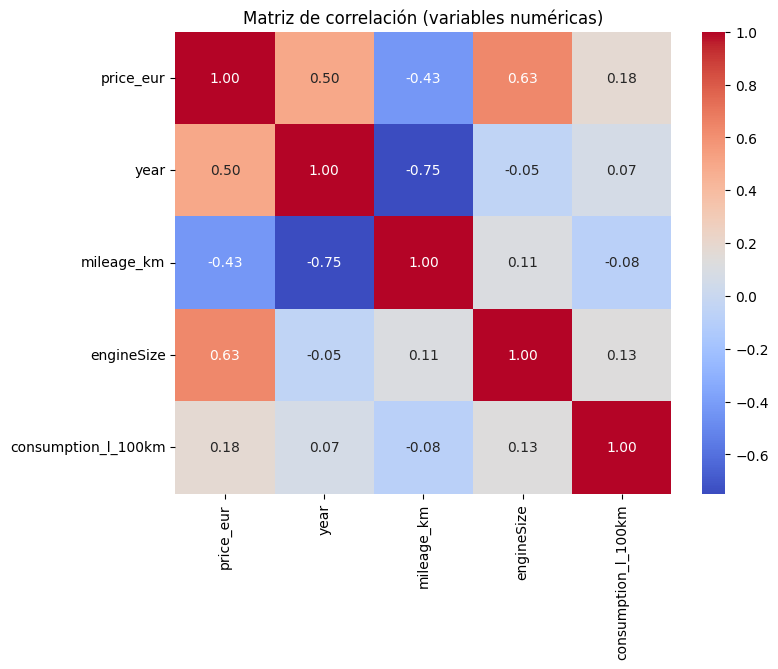

In [ ]:
num_cols = ['price_eur', 'year', 'mileage_km', 'engineSize', 'consumption_l_100km']

corr = cars[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación (variables numéricas)")
plt.show()


# Preparación de modelo

In [ ]:
#Creo columna car_age a partir del último año disponible
base_year = cars['year'].max()   # en tu dataset es 2020
cars['car_age'] = base_year - cars['year']

cars[['year', 'car_age']].head()

#Separacion de ejes

feature_cols = [
    'year',
    'car_age',
    'mileage_km',
    'engineSize',
    'consumption_l_100km',
    'brand',
    'model',
    'transmission',
    'fuelType'
]

X = cars[feature_cols] #Variables
y = cars[target] #Precio del  coche

#Columnas categorticas que CatBoost procesa de forma especial
cat_features = ['brand', 'model', 'transmission', 'fuelType']


In [63]:
X.isna().sum()


year                      0
car_age                   0
mileage_km                0
engineSize                0
consumption_l_100km    9352
brand                     0
model                     0
transmission              0
fuelType                  0
dtype: int64

# Divido el dataset en train y test

In [64]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


Parametros

In [66]:

#Pools: le decimos explícitamente qué columnas son categóricas
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)

model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
       #optimizacion MAE (error medio absoluto)
    n_estimators=2000,
    l2_leaf_reg=5,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    verbose=200
)

model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)


0:	learn: 7643.3575342	test: 7667.3588015	best: 7667.3588015 (0)	total: 96.9ms	remaining: 3m 13s
200:	learn: 1750.9052413	test: 1787.4014394	best: 1787.4014394 (200)	total: 16.3s	remaining: 2m 25s
400:	learn: 1559.2654031	test: 1609.5828786	best: 1609.5828786 (400)	total: 32.7s	remaining: 2m 10s
600:	learn: 1458.3050897	test: 1523.3679226	best: 1523.3679226 (600)	total: 49s	remaining: 1m 54s
800:	learn: 1394.5797236	test: 1476.9334790	best: 1476.9334790 (800)	total: 1m 5s	remaining: 1m 38s
1000:	learn: 1357.0982266	test: 1451.0103374	best: 1451.0103374 (1000)	total: 1m 22s	remaining: 1m 22s
1200:	learn: 1330.2433053	test: 1432.5798626	best: 1432.5798626 (1200)	total: 1m 38s	remaining: 1m 5s
1400:	learn: 1311.8305677	test: 1421.0960906	best: 1421.0960906 (1400)	total: 1m 55s	remaining: 49.5s
1600:	learn: 1295.2852314	test: 1410.7323503	best: 1410.7323503 (1600)	total: 2m 13s	remaining: 33.3s
1800:	learn: 1282.4256656	test: 1403.4282593	best: 1403.4282593 (1800)	total: 2m 31s	remaining: 

# Evaluacion del modelo

In [68]:
y_pred = model.predict(test_pool)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:,.2f} €")
print(f"RMSE : {rmse:,.2f} €")
print(f"R²   : {r2:.4f}")


MAE  : 1,398.40 €
RMSE : 2,402.76 €
R²   : 0.9563


In [69]:
#Importancia de cada columna

importances = model.get_feature_importance(train_pool)

fi_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

fi_df


,feature,importance
3,engineSize,29.136456
5,brand,14.333853
4,consumption_l_100km,13.010399
1,car_age,10.524126
6,model,10.008622
2,mileage_km,8.266040
0,year,6.874454
7,transmission,4.248313
8,fuelType,3.597737


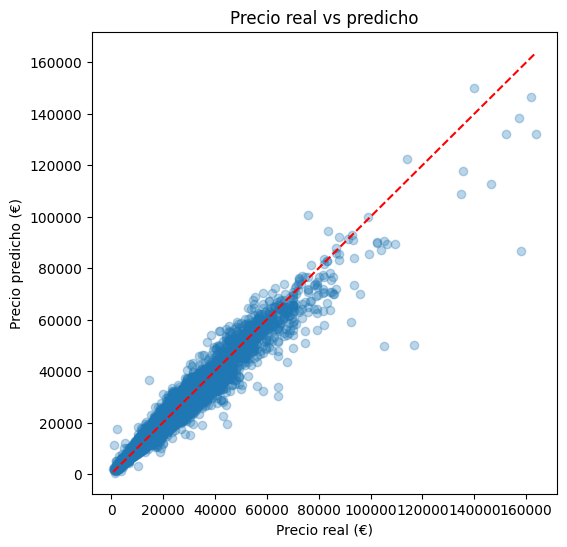

In [70]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Precio real (€)")
plt.ylabel("Precio predicho (€)")
plt.title("Precio real vs predicho")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


## Guardar modelo

In [ ]:
# Guardar el modelo entrenado
model.save_model("catboost_cars.cbm")

# Guardar el dataset limpio (el cars que ya tiene price_eur, mileage_km, etc.)
cars.to_csv("cars_clean.csv", index=False)


In [ ]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import streamlit as st
from catboost import CatBoostRegressor, Pool

#Cargar modelo y datos

@st.cache_resource
def load_model():
    model = CatBoostRegressor()
    model.load_model("catboost_cars.cbm")
    return model

@st.cache_data
def load_data():
    cars = pd.read_csv("cars_clean.csv")
    return cars

model = load_model()
cars = load_data()

#Columnas categóricas que usamos en el entrenamiento
CAT_FEATURES = ['brand', 'model', 'transmission', 'fuelType']

#Métricas del modelo (con mis números exactos del notebook)
MAE_MODEL = 1417.13
R2_MODEL = 0.9565


#Configuración de la página

st.set_page_config(
    page_title="Precio de coches - CatBoost",
    page_icon="🚗",
    layout="centered"
)

st.title("🚗 Estimador de precio de coches")
st.write("Modelo de **Machine Learning (CatBoost)** entrenado con anuncios reales de coches de segunda mano.")

#Sidebar con métricas del modelo
st.sidebar.header("📊 Calidad del modelo")
st.sidebar.metric("MAE (error medio)", f"{MAE_MODEL:,.0f} €")
st.sidebar.metric("R²", f"{R2_MODEL:.3f}")

st.sidebar.info(
    "El MAE es el error medio en euros. "
    "Por ejemplo, un MAE de ~1.400 € significa que, de media, el modelo se equivoca unos 1.400 € arriba o abajo."
)


#Formularios de entrada

st.header("Introduce las características del coche")

#Opciones sacadas del dataset real
brand_options = sorted(cars['brand'].unique())
brand = st.selectbox("Marca", brand_options)

model_options = sorted(cars[cars['brand'] == brand]['model'].unique())
modelo = st.selectbox("Modelo", model_options)

years = sorted(cars['year'].unique())
year = st.selectbox("Año", years, index=len(years) - 1)

engine_sizes = sorted(cars['engineSize'].unique())
engineSize = st.selectbox("Cilindrada (L)", engine_sizes)

transmissions = sorted(cars['transmission'].unique())
transmission = st.selectbox("Transmisión", transmissions)

fuel_types = sorted(cars['fuelType'].unique())
fuelType = st.selectbox("Tipo de combustible", fuel_types)

#Kilómetros y consumo: Numericos libres
avg_mileage = int(cars['mileage_km'].median())
mileage_km = st.number_input(
    "Kilómetros (km)",
    min_value=0,
    max_value=500_000,
    value=avg_mileage,
    step=1000
)

avg_consumption = float(cars['consumption_l_100km'].median())
consumption_l_100km = st.number_input(
    "Consumo (L/100 km)",
    min_value=2.0,
    max_value=20.0,
    value=round(avg_consumption, 1),
    step=0.1
)



if st.button("🔮 Predecir precio"):
    #Construimos el DataFrame con una sola fila
    data = {
        'model': [modelo],
        'year': [year],
        'mileage_km': [mileage_km],
        'engineSize': [engineSize],
        'consumption_l_100km': [consumption_l_100km],
        'brand': [brand],
        'transmission': [transmission],
        'fuelType': [fuelType]
    }
    df_input = pd.DataFrame(data)

    #Creamos el Pool igual que en el notebook
    pool_input = Pool(df_input, cat_features=CAT_FEATURES)

    #Predicción
    pred_price = model.predict(pool_input)[0]

    #Intervalo aproximado usando el MAE
    min_price = pred_price - MAE_MODEL
    max_price = pred_price + MAE_MODEL

    st.subheader("💰 Resultado")
    st.success(f"Precio estimado: **{pred_price:,.0f} €**")

    st.write(
        f"Intervalo aproximado según el error medio del modelo: "
        f"entre **{min_price:,.0f} €** y **{max_price:,.0f} €**."
    )

    st.caption(
        "Este intervalo está basado en el MAE global del modelo, "
        "es decir, el error medio observado al validarlo con datos reales."
    )


2025-11-20 23:10:51.661 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-11-20 23:10:51.661 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-20 23:10:51.976 
  command:

    streamlit run c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-20 23:10:51.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-20 23:10:51.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-20 23:10:51.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-20 23:10:51.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-20 23:10:51